In [ ]:
import numpy as np
import pandas as pd
import numpy.random as R
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import qmc
import global_as_gaussian_quad as global_as_gaussian_quad

import global_as

epsilon = 0.001
def dFunc(x):
    chi, dim = x.shape[0], x.shape[1]
    xe = np.tile(x.transpose(), dim).transpose()+np.repeat(np.array(np.identity(dim)*epsilon), chi, axis=0)
    return ((Func(xe)-np.tile(Func(x),dim))/epsilon).reshape(dim,chi)

In [ ]:
dim = 10
theta = np.array(np.arange(1,dim+1,1)) 
chi = 20000
def Func(x):
    x = x - 0.5
    return x@theta + 10*(x[:,0]*x[:,1] - x[:,-1]*x[:,-2]) + 0.0*R.normal(0,1,x.shape[0]) 

sample_list = []
for i in range(10):
    z3 = R.uniform(0, 1, (1000000, dim))
    sample_list.append(np.mean(Func(z3)))
sample_list = sum(sample_list)/len(sample_list)
sigma2 = sum((Func(R.uniform(0, 1, (1000000, dim))) - sample_list)**2)/1000000
sigma2

33.47989854418904

In [34]:
### Calculate upper and lower Sobol' indices
x, z, w = R.uniform(0, 1, (chi, dim)), R.uniform(0, 1, (chi, dim)), R.uniform(0, 1, (chi, dim))
upper, lower = [], []
for i in range(dim):
    fx, fz = Func(x), Func(z)
    x_uz, z_ux, w_ux = z.copy(), x.copy(), x.copy()
    x_uz[:,i], z_ux[:,i], w_ux[:,i] = x[:,i], z[:,i], w[:,i]
    upper.append(0.5*sum((fx - Func(z_ux))**2)/chi/sigma2)
    lower.append(sum((Func(x_uz) - fz)*(fx - Func(w_ux)))/chi/sigma2)

print(upper)
print(lower)

[0.022560466425270296, 0.030695462210987963, 0.022499009735459295, 0.0399255810422794, 0.0625942279263412, 0.08965689280320742, 0.11974164860245794, 0.15847314613708938, 0.2206698669873422, 0.26914835109303886]
[0.0021862992198368224, 0.010168349795746994, 0.02273491209464058, 0.03965106193247229, 0.06253621512103903, 0.09005860629169915, 0.12200340907855374, 0.1563373220149727, 0.20442570576958832, 0.24625301346832926]


In [35]:
### Calculate DGSM and full global activity scores
epsilon = 10**-3
z = R.uniform(0, 1, (chi, dim))
deriv = dFunc(z)
deriv /= np.sqrt(chi)
uo, so, vho = np.linalg.svd(deriv.astype(float), full_matrices=False)  
so = so**2
DGSM = uo**2@so/sum(uo**2@so)

# M2 = 1
# u, s = global_as.GAS(Func,dim,chi,int(chi/M2),M2,shiftedSobol=False, distribution = 'uniform') 
# gas_score_full = u**2@s/sum(u**2@s)

In [ ]:
M2 = 10
fd_result = global_as_gaussian_quad.calculate_finite_difference_matrix(
            f=Func,
            X=R.uniform(0, 1, (int(chi/2/M2), dim)),
            n_points=M2
        )
u, s, _ = np.linalg.svd(fd_result.T.astype(float), full_matrices=False)  
s = s**2
gas_score_full = u**2@s/sum(u**2@s)

In [12]:
pd.DataFrame(fd_result).to_csv('newton_Df_matrix_M2_eq_10.csv')

[0.93008021 0.95010269 0.97001599 0.98987665 1.         1.
 1.         1.         1.         1.        ]
[0.9322732  0.95223339 0.97162512 0.98956721 1.         1.
 1.         1.         1.         1.        ]


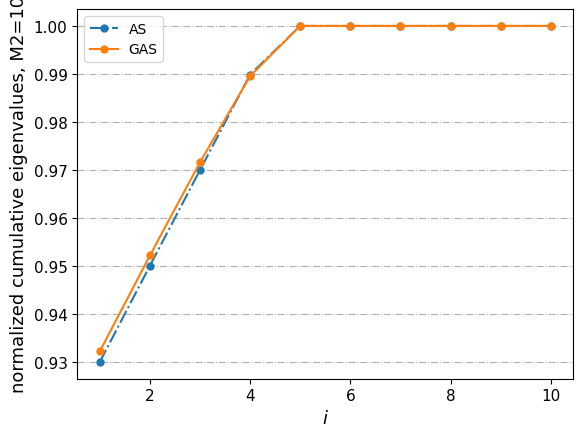

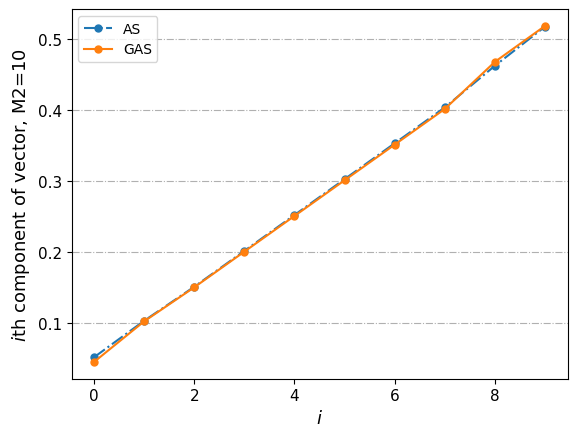

In [37]:
### Plot eigenvalues and eigenvectors
x=np.arange(1,1+len(s),1)
fig,ax=plt.subplots(figsize=(6.4,4.8), dpi=100)
colorc=plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.plot(x,np.cumsum(so)/np.sum(so), label='AS', c=colorc[0], linestyle='-.', marker='.', markersize='10')
print(np.cumsum(so)/np.sum(so))
ax.plot(x,np.cumsum(s)/np.sum(s), label='GAS', c=colorc[1], linestyle='-', marker='.', markersize='10')
print(np.cumsum(s)/np.sum(s))
ax.set_xlabel('$i$', fontsize=13)
ax.set_ylabel('normalized cumulative eigenvalues, M2='+ str(M2), fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.yaxis.grid(True, linestyle='-.')

legend = ax.legend(loc='best')
#plt.title('Normalized cumulative eigenvalues') 
plt.savefig('gascore_paper/10E1_' + str(M2) + '.png')

x=np.arange(0,len(s),1)
fig,ax=plt.subplots(figsize=(6.4,4.8), dpi=100)
colorc=plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.plot(x,-uo[:,0], label='AS', c=colorc[0], linestyle='-.', marker='.', markersize='10')
ax.plot(x,-u[:,0], label='GAS', c=colorc[1], linestyle='-', marker='.', markersize='10')
ax.set_xlabel('$i$', fontsize=13)
ax.set_ylabel('$i$th component of vector, M2='+ str(M2), fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.yaxis.grid(True, linestyle='-.')

legend = ax.legend(loc='best')
#plt.title('The 1st eigenvectors') 
plt.savefig('gascore_paper/10E2_' + str(M2) + '.png')

In [39]:
### Calculate activity scores and global activity scores
d1 = 1
as_score = uo[:,:d1]**2@so[:d1]/sum(uo[:,:d1]**2@so[:d1])
print(as_score)
d1 =1
gas_score = u[:,:d1]**2@s[:d1]/sum(u[:,:d1]**2@s[:d1])
print(gas_score)

[0.00271514 0.01069171 0.02288149 0.0406782  0.06355969 0.09152595
 0.12457698 0.1627128  0.21340191 0.26725614]
[0.00207221 0.01052466 0.02263755 0.04024454 0.06288209 0.09055022
 0.12324891 0.16097816 0.218533   0.26832866]


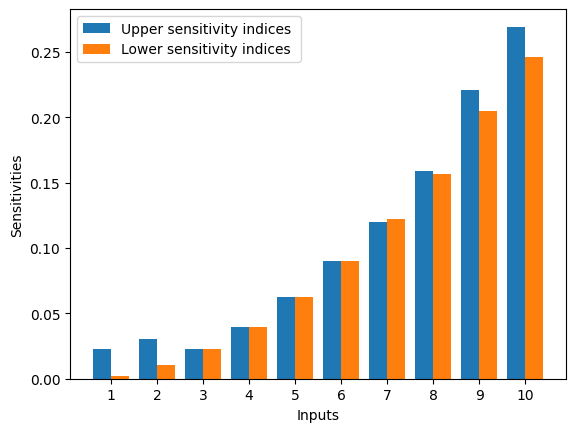

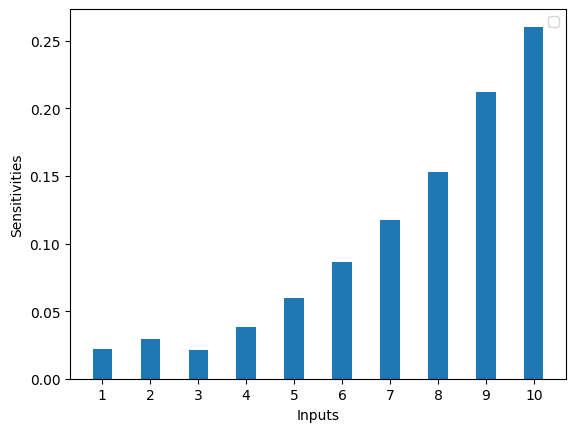

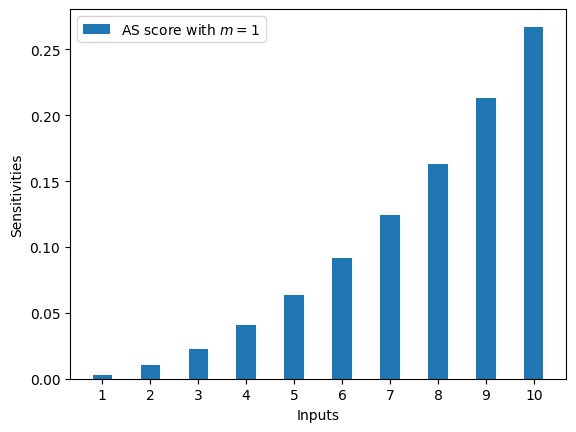

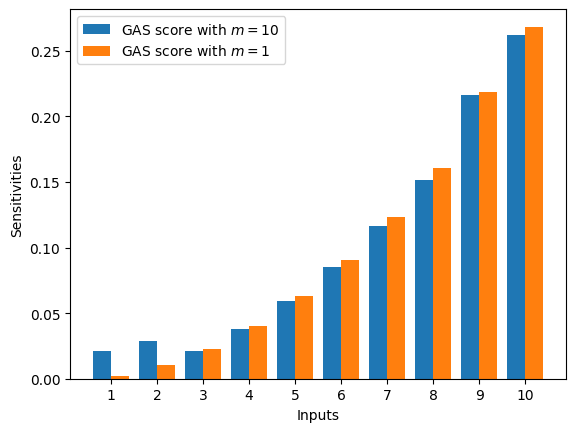

In [40]:
### Plot all indices
width = 0.4
x = np.arange(1,dim+1)
labels = x
fig, ax1 = plt.subplots()
rects1 = ax1.bar(x-width/2, upper, width, label='Upper sensitivity indices')
rects2 = ax1.bar(x+width/2, lower, width, label='Lower sensitivity indices ')
ax1.set_ylabel('Sensitivities')
ax1.set_xlabel('Inputs')
ax1.set_xticks(x)
ax1.legend(loc='upper left')
plt.savefig('gascore_paper/sobol10.png')

fig, ax2 = plt.subplots()
rects1 = ax2.bar(x, DGSM, width)
ax2.set_ylabel('Sensitivities')
ax2.set_xlabel('Inputs')
ax2.set_xticks(x)
ax2.legend()
plt.savefig('gascore_paper/dgsm10.png')

fig, ax3 = plt.subplots()
rects1 = ax3.bar(x, as_score, width, label='AS score with $m = 1$')
ax3.set_ylabel('Sensitivities')
ax3.set_xlabel('Inputs')
ax3.set_xticks(x)
ax3.legend(loc='upper left')
plt.savefig('gascore_paper/as10.png')

fig, ax4 = plt.subplots()
rects1 = ax4.bar(x-width/2, gas_score_full, width, label='GAS score with $m = 10$')
rects2 = ax4.bar(x+width/2, gas_score, width, label='GAS score with $m = 1$')
ax4.set_ylabel('Sensitivities')
ax4.set_xlabel('Inputs')
ax4.set_xticks(x)
ax4.legend(loc='upper left')
plt.savefig('gascore_paper/gas10.png')

In [ ]:
result1 = [[0]*10]*4
result2 = [[0]*10]*4

for j,chi in enumerate([100,1000,10000,100000]):
    ### Calculate upper and lower Sobol' indices
    x, z, w = R.uniform(0, 1, (chi, dim)), R.uniform(0, 1, (chi, dim)), R.uniform(0, 1, (chi, dim))
    upper, lower = [], []
    for i in range(dim):
        fx, fz = Func(x), Func(z)
        x_uz, z_ux, w_ux = z.copy(), x.copy(), x.copy()
        x_uz[:,i], z_ux[:,i], w_ux[:,i] = x[:,i], z[:,i], w[:,i]
        upper.append(0.5*sum((fx - Func(z_ux))**2)/chi/sigma2)    
    result1[j] = upper

    fd_result = global_as_gaussian_quad.calculate_finite_difference_matrix(
            f=Func,
            X=R.uniform(0, 1, (int(chi/2/M2), dim)),
            n_points=10
        )
    u, s, _ = np.linalg.svd(fd_result.T.astype(float), full_matrices=False)  
    s = s**2
    result2[j] = u**2@s/sum(u**2@s)

/var/folders/3g/94n8wq0x2173q3pr5zt6vy940000gq/T/ipykernel_95321/821025407.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('tab20', 14)


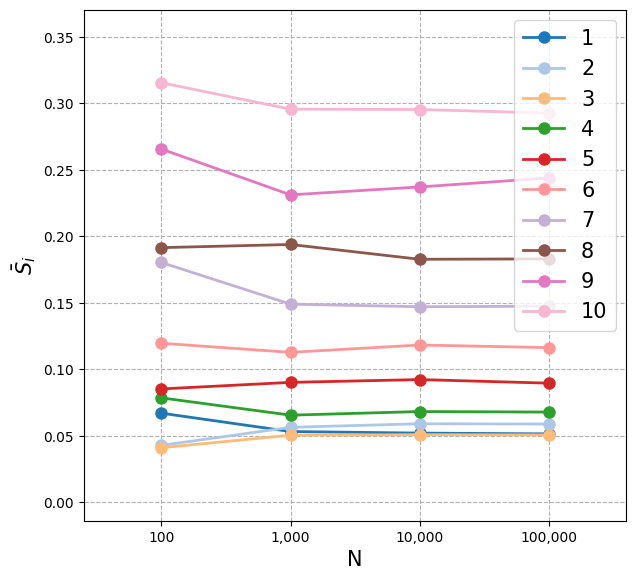

In [15]:
import matplotlib as mpl
cmap = mpl.cm.get_cmap('tab20', 14)
colors = cmap(np.linspace(0, 1, 14))

ac_score1 = []
Nlist = [1,2,3,4]
dim = 10
in_labels = Nlist
text = [str(i) for i in Nlist]
result = np.transpose(result1)

plt.figure(figsize=(7,7))
plt.rc('font')
for i in range(dim):
    plt.plot(np.array(Nlist), result[i], 'o-', markersize=8,linewidth=2,clip_on=False,color = colors[i],label = str(i+1))
plt.xticks(np.arange(1,5), ['100','1,000','10,000','100,000']) 
plt.xlabel('N', fontsize = 15)
plt.ylabel(r'$\bar S_i$', fontsize = 15)
plt.grid(True,linestyle = '--')
plt.legend(prop={'size': 15}, loc='upper right')
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)
plt.savefig('gascore_paper/noise1.png')

/var/folders/3g/94n8wq0x2173q3pr5zt6vy940000gq/T/ipykernel_95321/3640866520.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('tab20', 14)


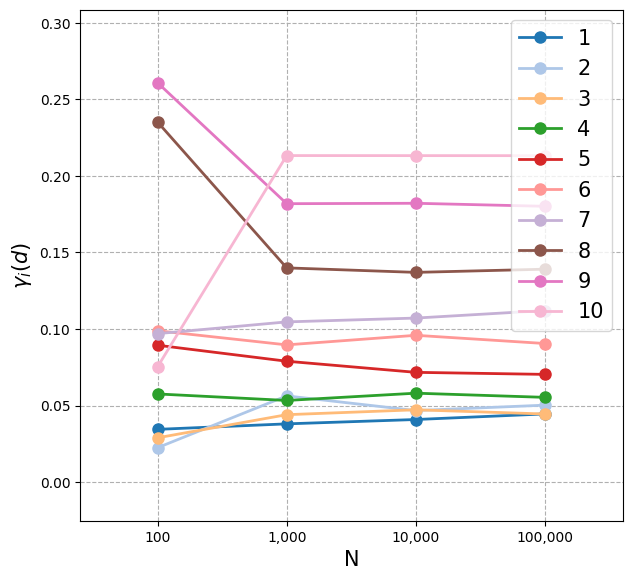

In [16]:
import matplotlib as mpl
cmap = mpl.cm.get_cmap('tab20', 14)
colors = cmap(np.linspace(0, 1, 14))

ac_score1 = []
Nlist = [1,2,3,4]
dim = 10
in_labels = Nlist
text = [str(i) for i in Nlist]
result = np.transpose(result2)

plt.figure(figsize=(7,7))
plt.rc('font')
for i in range(dim):
    plt.plot(np.array(Nlist), result[i], 'o-', markersize=8,linewidth=2,clip_on=False,color = colors[i],label = str(i+1))
plt.xticks(np.arange(1,5), ['100','1,000','10,000','100,000']) 
plt.xlabel('N', fontsize = 15)
plt.ylabel(r'$\gamma_i(d)$', fontsize = 15)
plt.grid(True,linestyle = '--')
plt.legend(prop={'size': 15}, loc='upper right')
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)
plt.savefig('gascore_paper/noise2.png')